# USPEX SXD point-source reduction example

Last updated 21 June 2023

This notebook demonstrates the reduction of a SXD point-source data using the test data provided with the code


## Steps:
* setup instrument parameters (WORKING)
* reduce calibration data (WORKING)
* extract science point source (WORKING)
* extract telluric standard point source (WORKING)
* combine individual science spectra into one spectrum (WORKING)
* combine individual telluric spectra into one spectrum (WORKING)
* telluric calibration science spectrum (TBD)
* stitch orders for SXD data (TBD)


In [1]:
# import package and check
import pyspextool as ps
import os
import numpy as np
import matplotlib.pyplot as pl

help(ps)

Help on package pyspextool:

NAME
    pyspextool

DESCRIPTION
    PySpexTool is a package intended to contain core functionality and some
    common tools needed for performing reduction for SpeX instrument in
    Python.

PACKAGE CONTENTS
    combine (package)
    config
    extract (package)
    fit (package)
    io (package)
    plot (package)
    setup_utils
    utils (package)

FILE
    /Users/adam/python_codes/pyspextool/src/pyspextool/__init__.py




In [2]:
# initial imports and setup
import pyspextool as ps
import os

# what instrument and mode we are using
instrument = 'uspex'
mode = 'SXD'

# point to test data folder for USPEX SXD data
# NOTE: this should be moved internally
pfolder = os.path.dirname(os.path.abspath(ps.__file__))+'/../../'
tdfolder = pfolder+'/test_data/{}-{}/'.format(instrument,mode)

# set output pathways
redux_folder = '/Users/adam/projects/spex_archive/test_spex-SXD/'
raw_path = tdfolder
cal_path = redux_folder+'/cals/'
proc_path = redux_folder+'/proc/'
qa_path = redux_folder+'/cals/'

# file prefixes
src_prefix = 'spc-'
flat_prefix = 'flat-'
arc_prefix = 'arc-'

# file numbers
flat_files = '21-25'
arc_files = '26'
src_files = '1-8'
tell_files = '11-18'
combine_prefix = 'combspec'

# extraction details
orders = '3-9' # orders to extract
source_type = 'ps' # source type: 'ps' (default) or 'xs'
reduction_mode = 'A-B' # reduction mode: 'A-B' (default), 'A', 'A-Sky/Dark'
npos = 2
aperture_positions = [3.7, 11.2] # preset aperture positions
aperture_method = 'auto' # method to identify aperture: 'fixed', 'guess', or 'auto' (default)
ps_aperture = 1.5 # preset aperture width for point source in multiples of PSF radius
psf_radius = 1.5 # point source PSF radius
ps_bg_parameters = [2.5,4] # point source background parameters; radius to start, then width
combine_prefix = 'combspec'
#scale_range = [1.0,1.5]

# set up instrument
ps.pyspextool_setup(instrument,raw_path=raw_path, cal_path=cal_path, proc_path=proc_path, qa_path=qa_path,verbose=True)



Pyspextool Setup
----------------
Instrument:  uspex

Rawpath:  /Users/adam/python_codes/pyspextool/test_data/uspex-SXD
Calpath:  /Users/adam/projects/spex_archive/test_uspex-SXD/cals
Procpath:  /Users/adam/projects/spex_archive/test_uspex-SXD/proc
Qapath:  /Users/adam/projects/spex_archive/test_uspex-SXD/cals

QA Extension: .pdf
QA Plot: False
QA File: True 



Generating Flat Field
---------------------
Loading images...
100% |**********************************************************************|
Scaling images...
Medianing the images...
Locating the orders...
Normalizing the median image...
Normalizing the flat...
100% |**********************************************************************|
Writing flat to disk...
Flat field flat21-25.fits written to disk.

Generating Wavelength Solution
------------------------------
Loading images...
100% |**********************************************************************|


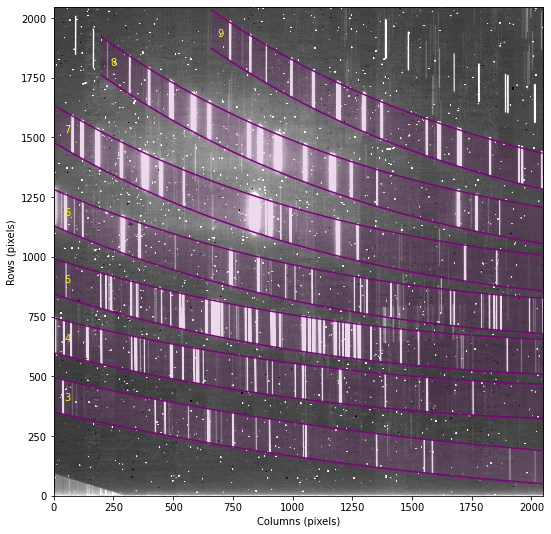

Extracting 1 apertures in 7 orders (without background subtraction)...
100% |**********************************************************************|


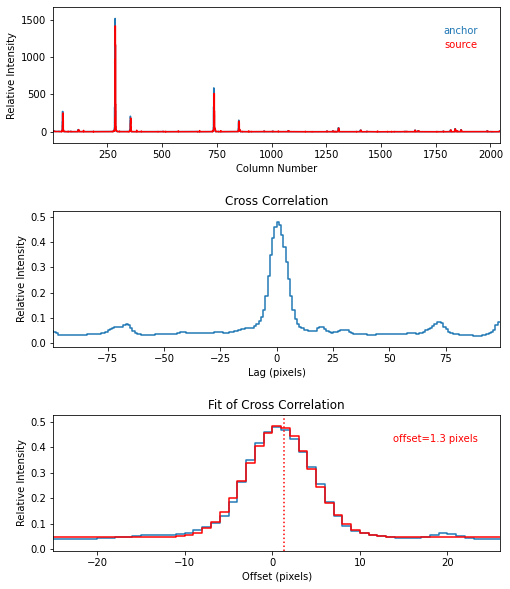

Finding the lines...


/Users/adam/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


100% |**********************************************************************|
Determining the wavelength solution...


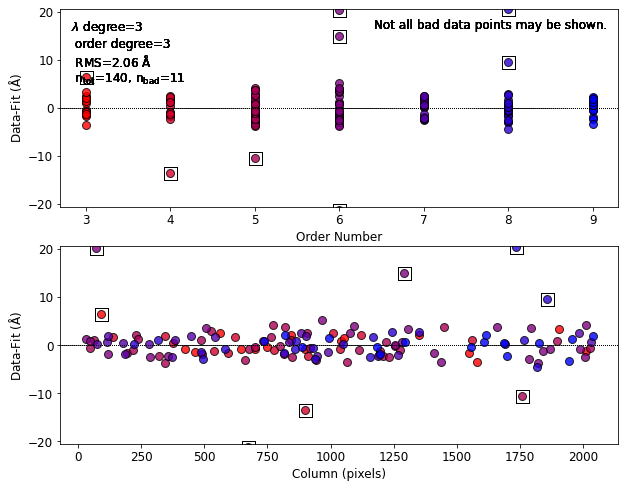

Writing wavecal to disk...
Wavecal wavecal26.fits written to disk.



In [3]:
# conduct calibrations
ps.extract.make_flat([flat_prefix,flat_files],'flat{}'.format(flat_files),qa_plot=False,qa_file=True,verbose=True)

ps.extract.make_wavecal([arc_prefix,arc_files],'flat{}.fits'.format(flat_files),'wavecal{}'.format(arc_files),\
    qa_file=True,qa_plot=True,use_stored_solution=False,verbose=True)


In [4]:
# extract first two images of science target

# load in images and apply flat and wavecal calbrations
ps.extract.load_image([src_prefix,ps.io.files.extract_filestring(src_files,method='index')[:2]],\
                      'flat{}.fits'.format(flat_files), 'wavecal{}.fits'.format(arc_files),\
                      flat_field=True, linearity_correction=True,reduction_mode=reduction_mode, \
                      qa_plot=False, qa_file=True, verbose=True)

# set extraction method to point source
ps.extract.set_extraction_type(source_type)

# make spatial profiles
ps.extract.make_spatial_profiles(qa_plot=False, qa_file=False, verbose=True)

# identify aperture positions (set above)
if aperture_method=='auto': # this works for method = 'auto'
    ps.extract.locate_aperture_positions(2, method=aperture_method, qa_plot=False, qa_file=False, verbose=True)
else:
    ps.extract.locate_aperture_positions(aperture_positions, method=aperture_method, qa_plot=False, qa_file=False, verbose=True)

# select orders to extract (set above)
ps.extract.select_orders(include=orders, qa_plot=False, qa_file=False, verbose=True)

# trace apertures
ps.extract.trace_apertures(qa_plot=False, qa_file=True, verbose=True)

# define the aperture - psf, width, background
ps.extract.define_aperture_parameters(ps_aperture, psf_radius=psf_radius,bg_radius=ps_bg_parameters[0],\
                        bg_width=ps_bg_parameters[1], qa_plot=False, qa_file=True)

# extract away
ps.extract.extract_apertures(verbose=True)

# conduct extraction of all remaining files
# NOTE: this is redundant for the first two files,
ps.extract.do_all_steps([src_prefix,src_files])


Loading the flat...
Loading the wavecal...
Loading spc-00001.a.fits, spc-00002.b.fits and correcting for non-linearity...
Loading images...
100% |**********************************************************************|
Flat fielding the image...
Setting extraction type to point source...
Creating the spatial profiles...
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...


/Users/adam/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 7 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00001 to disk.
Wrote spectra00002 to disk.
 
Loading spc-00001.a.fits, spc-00002.b.fits and correcting for non-linearity...
Loading images...
100% |**********************************************************************|
Flat fielding the image...
Previous steps not completed.
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...


/Users/adam/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 7 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00001 to disk.
Wrote spectra00002 to disk.
 
Do All Steps Complete.
Loading spc-00004.a.fits, spc-00003.b.fits and correcting for non-linearity...
Loading images...
100% |**********************************************************************|
Flat fielding the image...
Previous steps not completed.
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...


/Users/adam/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 7 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00004 to disk.
Wrote spectra00003 to disk.
 
Do All Steps Complete.
Loading spc-00005.a.fits, spc-00006.b.fits and correcting for non-linearity...
Loading images...
100% |**********************************************************************|
Flat fielding the image...
Previous steps not completed.
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...


/Users/adam/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 7 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00005 to disk.
Wrote spectra00006 to disk.
 
Do All Steps Complete.
Loading spc-00008.a.fits, spc-00007.b.fits and correcting for non-linearity...
Loading images...
100% |**********************************************************************|
Flat fielding the image...
Previous steps not completed.
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...


/Users/adam/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Tracing apertures...
100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 7 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00008 to disk.
Wrote spectra00007 to disk.
 
Do All Steps Complete.


In [5]:
# now do telluric source

# load in images and apply flat and wavecal calbrations
ps.extract.load_image([src_prefix,ps.io.files.extract_filestring(tell_files,method='index')[:2]],\
                      'flat{}.fits'.format(flat_files), 'wavecal{}.fits'.format(arc_files),\
                      flat_field=True, linearity_correction=True,reduction_mode=reduction_mode, \
                      qa_plot=False, qa_file=True, verbose=True)

# set extraction method to point source
ps.extract.set_extraction_type(source_type)

# make spatial profiles
ps.extract.make_spatial_profiles(qa_plot=False, qa_file=False, verbose=True)

# identify aperture positions (set above)
if aperture_method=='auto': # this works for method = 'auto'
    ps.extract.locate_aperture_positions(2, method=aperture_method, qa_plot=False, qa_file=False, verbose=True)
else:
    ps.extract.locate_aperture_positions(aperture_positions, method=aperture_method, qa_plot=False, qa_file=False, verbose=True)

# select orders to extract (set above)
ps.extract.select_orders(include=orders, qa_plot=False, qa_file=False, verbose=True)

# trace apertures
ps.extract.trace_apertures(qa_plot=False, qa_file=True, verbose=True)

# define the aperture - psf, width, background
ps.extract.define_aperture_parameters(ps_aperture, psf_radius=psf_radius,bg_radius=ps_bg_parameters[0],\
                        bg_width=ps_bg_parameters[1], qa_plot=False, qa_file=True)

# extract away
ps.extract.extract_apertures(verbose=True)

# now do all files
ps.extract.do_all_steps([src_prefix,tell_files])


Loading the flat...
Loading the wavecal...
Loading spc-00011.a.fits, spc-00012.b.fits and correcting for non-linearity...
Loading images...
100% |**********************************************************************|
Flat fielding the image...
Setting extraction type to point source...
Creating the spatial profiles...
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...


/Users/adam/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 7 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00011 to disk.
Wrote spectra00012 to disk.
 
Loading spc-00011.a.fits, spc-00012.b.fits and correcting for non-linearity...
Loading images...
100% |**********************************************************************|
Flat fielding the image...
Previous steps not completed.
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...


/Users/adam/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 7 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00011 to disk.
Wrote spectra00012 to disk.
 
Do All Steps Complete.
Loading spc-00014.a.fits, spc-00013.b.fits and correcting for non-linearity...
Loading images...
100% |**********************************************************************|
Flat fielding the image...
Previous steps not completed.
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...
100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 7 orders (with background subtraction)...
100% |***************************************************

/Users/adam/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Tracing apertures...
100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 7 orders (with background subtraction)...
100% |**********************************************************************|
Wrote spectra00015 to disk.
Wrote spectra00016 to disk.
 
Do All Steps Complete.
Loading spc-00018.a.fits, spc-00017.b.fits and correcting for non-linearity...
Loading images...
100% |**********************************************************************|
Flat fielding the image...
Previous steps not completed.
Locating the apertures...
Aperture signs are (+, -)...
Updating order selection...
Tracing apertures...
100% |**********************************************************************|
100% |**********************************************************************|
Extracting 2 apertures in 7 orders (with background subtraction)...
100% |******************************

## Combine science and telluric spectra into a single spectrum each

In [8]:
# NOTE: Setting qa_plot and qa_file = False due to plotting issue with combined spectra
# source
ps.combine.combine_spectra(['spectra',src_files],'{}{}'.format(combine_prefix,src_files),\
      scale_spectra=True,correct_spectral_shape=False,qa_plot=False,qa_file=False,verbose=True)

# telluric star
ps.combine.combine_spectra(['spectra',tell_files],'{}{}'.format(combine_prefix,tell_files),\
      scale_spectra=True,correct_spectral_shape=True,qa_plot=False,qa_file=False,verbose=True)


Combining Spectra
-----------------
Loading spectra...
Scaling the spectra...
Combining spectra...
Writing spectra to disk...
Wrote combspec1-8.fits.fits to disk.
Combining Spectra
-----------------
Loading spectra...
Scaling the spectra...
Combining spectra...
Writing spectra to disk...
Wrote combspec11-18.fits.fits to disk.


## Flux calibrate science spectrum with telluric spectrum

[This has not been completed yet]

# Checking your outputs

You should find several output files in your cals and proc folders that allow you to visualize the calibrations and extractions. In addition, you can read in the spectrum and visualize it with plot_spectra.py


In [ ]:
# plot with default parameters
################################################
# NOTE: CURRENTLY FAILING DUE TO ISSUE IN plot_spectra.py/get_ranges()
################################################
from pyspextool.plot.plot_spectra import plot_spectra

file = 'combspec1-8.fits'
plot_spectra(proc_path+file,colors='k',ytype="flux and uncertainty",order_numbers=False)

In [51]:
# Altnerate plotting function for interim
from pyspextool.io.read_spectra_fits import read_spectra_fits
def plotsxd(file,ytype="flux and uncertainty",plotall=True,figure_size=(7,5),color='k',
            line_width=1):
# check file
    if os.path.exists(file)==False: raise ValueError('File {} cannot be found'.format(file))
        
    spectra, info = read_spectra_fits(file)
    orders = info['orders']
#    napertures = info['napertures'] # ignoring
    latex_yunits = info['lyunits']
    latex_xlabel = info['lxlabel']
    latex_ylabel = info['lylabel']
    orders = info['orders']

    if ytype == 'flux': ylabel = latex_ylabel
    elif ytype == 'uncertainty': ylabel = 'Uncertainty (' + latex_yunits + ')'
    elif ytype == 'snr': ylabel = 'Signal to Noise'
    elif ytype == 'flux and uncertainty': ylabel = latex_ylabel       
    else: raise ValueError('Do not recognize y axis name {}'.format(ytype))    

    for i,o in enumerate(orders):
        if plotall==False or (plotall==True and i==0): 
            figure = pl.figure(num=i, figsize=figure_size)
            pl.clf()
            ax = figure.add_axes([0.125, 0.11, 0.775, 0.77])
            ax.plot([np.nan], [np.nan])

        xvalues = spectra[i, 0, :] 
        y2values = [np.nan]*len(xvalues)
        if ytype == 'flux': yvalues = spectra[i,1,:]
        elif ytype == 'uncertainty': yvalues = spectra[i,2,:]
        elif ytype == 'snr': yvalues = spectra[i,1,:]/spectra[i,2,:]
        elif ytype == 'flux and uncertainty':
            yvalues = spectra[i,1,:]
            y2values = spectra[i,2,:]            

        ax.plot(xvalues, yvalues, color=color, ls='-', lw=line_width)
        ax.plot(xvalues, y2values, color='grey', lw=line_width)

        w = np.where(np.isfinite(yvalues)==True)
        xrange=[np.nanmin(xvalues[w]),np.nanmax(xvalues[w])]
        ave_wave = np.nanmedian(xvalues[w])
        yrange=np.nanquantile(yvalues[w],[0.05,0.95])
        yrange=[yrange[0]-0.1*(yrange[1]-yrange[0]),yrange[1]+0.1*(yrange[1]-yrange[0])]
        if plotall==False:
            ax.set_xlim(xrange)
            ax.set_ylim(yrange)
            ax.set_xlabel(latex_xlabel)
            ax.set_ylabel(ylabel)
            ax.set_title('Order {}'.format(str(orders[i])))
        else:
            if i==0: xranges,yranges,oloc=xrange,yrange,[]
            else:
                xranges = [np.nanmin([xranges[0],xrange[0]]),np.nanmax([xranges[1],xrange[1]])]
                yranges = [np.nanmin([yranges[0],yrange[0]]),np.nanmax([yranges[1],yrange[1]])]
            oloc.append(ave_wave)

    if plotall==True:
        ax.set_xlim(xranges)
        ax.set_ylim(yranges)
        ax.set_xlabel(latex_xlabel)
        ax.set_ylabel(ylabel) 
        for i,o in enumerate(oloc): ax.text(o, yranges[1]+0.02*(yranges[1]-yranges[0]), str(orders[i]), color=color)

    pl.show()
    return 


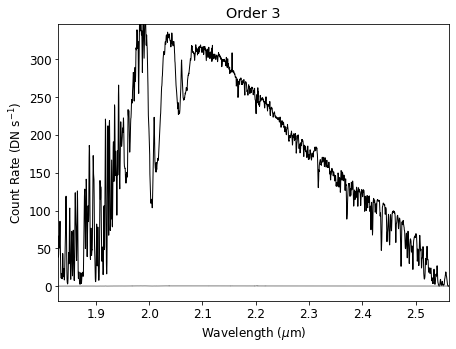

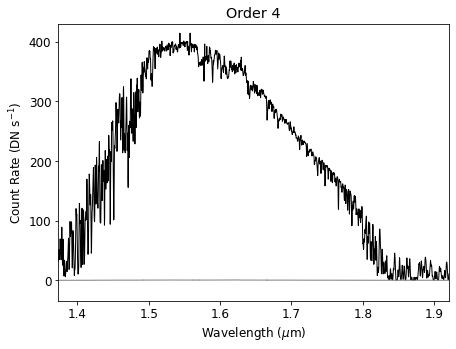

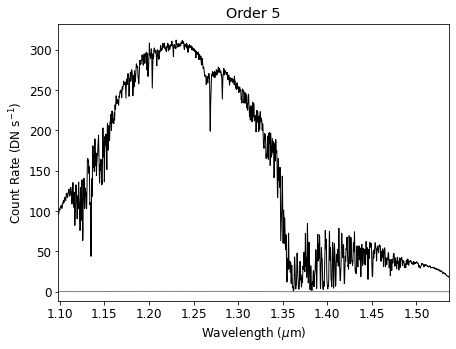

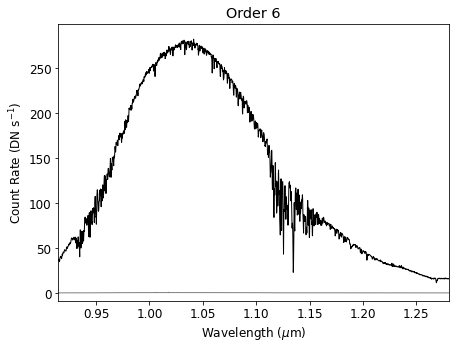

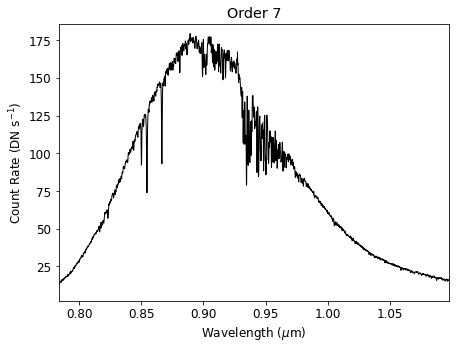

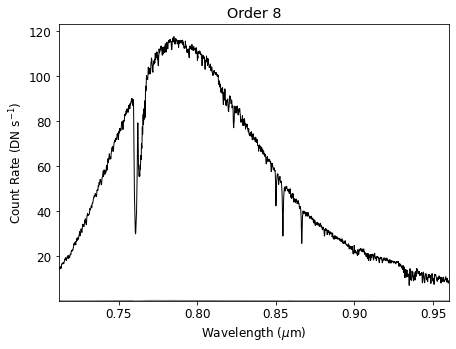

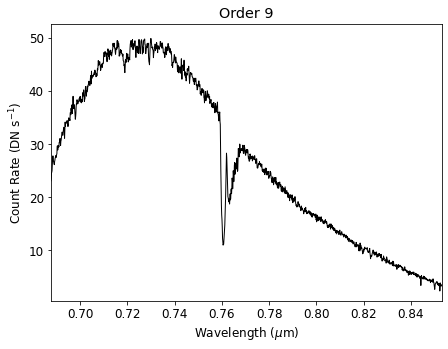

In [53]:
file = 'combspec1-8.fits'
plotsxd(proc_path+file,color='k',ytype="flux and uncertainty",plotall=False)

In [20]:
info

{'header': SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                  -64 / array data type                                
 NAXIS   =                    3 / number of array dimensions                     
 NAXIS1  =                 2040                                                  
 NAXIS2  =                    4                                                  
 NAXIS3  =                    7                                                  
 INSTR   = 'SpeX    '           / Instrument                                     
 MODE    = 'ShortXD '           / Instrument Mode                                
 FILENAME= 'combspec1-8.fits'   / File name                                      
 SRT_DATE= '2015-06-03'         / Start observations date in UTC                 
 AVE_DATE= '2015-06-03'         / Average observation date in UTC                
 END_DATE= '2015-06-03'         / End observation date in UTC                    
 SRT_T

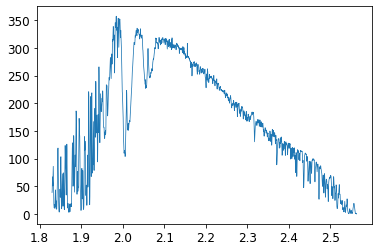

In [19]:
pl.plot(spectra[0,0,:],spectra[0,1,:],)